<a href="https://colab.research.google.com/github/AhsanRaza-dev/DeepLearning_Models/blob/main/Firre_Classification_v3_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.5 MB/s eta 0:00:00


In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing.image import ImageDataGenerator


# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-07-06 16:18:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-06 16:18:25 (52.3 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (320, 320)

In [ ]:
# Walk through each directory
dataset = '/content/drive/MyDrive/DataSets/fire_dataset'
walk_through_dir(dataset)

There are 2 directories and 1 images in '/content/drive/MyDrive/DataSets/fire_dataset'.
There are 0 directories and 248 images in '/content/drive/MyDrive/DataSets/fire_dataset/non_fire_images'.
There are 0 directories and 760 images in '/content/drive/MyDrive/DataSets/fire_dataset/fire_images'.


In [ ]:
import os
import csv

# Define the path to the dataset directory
dataset_dir = '/content/drive/MyDrive/DataSets/fire_dataset'

# Define the path to the output CSV file
output_csv = '/content/drive/MyDrive/DataSets/fire_dataset/fire_image_labels.csv'

# List to store image paths and labels
image_data = []

# Traverse the dataset directory
for class_dir in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_dir)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                image_data.append([image_path, class_dir])

# Write the image paths and labels to a CSV file
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_path', 'label'])  # Write header
    writer.writerows(image_data)

print(f'Labels saved to {output_csv}')

Labels saved to /content/drive/MyDrive/DataSets/fire_dataset/fire_image_labels.csv


In [ ]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)


In [ ]:
len(list(image_dir.glob(r'**/*.png')))

1008

In [ ]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/DataSets/fire_dataset/n...,non_fire_images
1,/content/drive/MyDrive/DataSets/fire_dataset/n...,non_fire_images
2,/content/drive/MyDrive/DataSets/fire_dataset/n...,non_fire_images
3,/content/drive/MyDrive/DataSets/fire_dataset/n...,non_fire_images
4,/content/drive/MyDrive/DataSets/fire_dataset/n...,non_fire_images
...,...,...
1003,/content/drive/MyDrive/DataSets/fire_dataset/f...,fire_images
1004,/content/drive/MyDrive/DataSets/fire_dataset/f...,fire_images
1005,/content/drive/MyDrive/DataSets/fire_dataset/f...,fire_images
1006,/content/drive/MyDrive/DataSets/fire_dataset/f...,fire_images


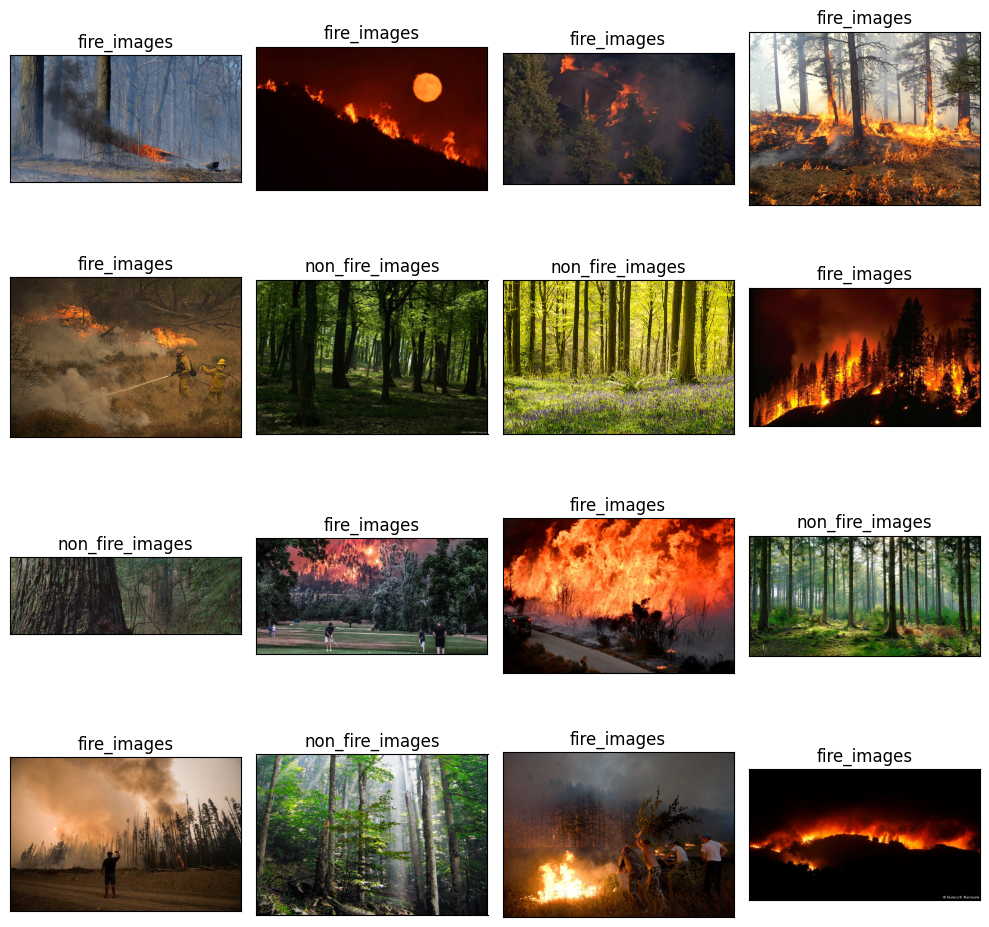

In [ ]:
import matplotlib.image as mpimg
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(image_df.Filepath[random_index[i]])
    ax.imshow(image)
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 645 validated image filenames belonging to 2 classes.
Found 161 validated image filenames belonging to 2 classes.
Found 202 validated image filenames belonging to 2 classes.


In [ ]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(300, 300, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [ ]:
# Create checkpoint callback
checkpoint_path = "Bone_Break_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=10,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

In [ ]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "Fire Classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/Fire Classification/20240706-174952
Epoch 1/100
21/21 [==============================] - 53s 2s/step - loss: 1.7670 - accuracy: 0.6543 - val_loss: 0.6914 - val_accuracy: 0.7516
Epoch 2/100
21/21 [==============================] - 46s 2s/step - loss: 0.9966 - accuracy: 0.6248 - val_loss: 0.5522 - val_accuracy: 0.7702
Epoch 3/100
21/21 [==============================] - 45s 2s/step - loss: 0.7294 - accuracy: 0.6899 - val_loss: 0.5754 - val_accuracy: 0.7702
Epoch 4/100
21/21 [==============================] - 51s 2s/step - loss: 0.7078 - accuracy: 0.7194 - val_loss: 0.4878 - val_accuracy: 0.7950
Epoch 5/100
21/21 [==============================] - 46s 2s/step - loss: 0.5904 - accuracy: 0.7581 - val_loss: 0.4168 - val_accuracy: 0.8199
Epoch 6/100
21/21 [==============================] - 47s 2s/step - loss: 0.5630 - accuracy: 0.7519 - val_loss: 0.4140 - val_accuracy: 0.8447
Epoch 7/100
21/21 [==============================] - 46s 2s/step - loss

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.30584
Test Accuracy: 88.61%


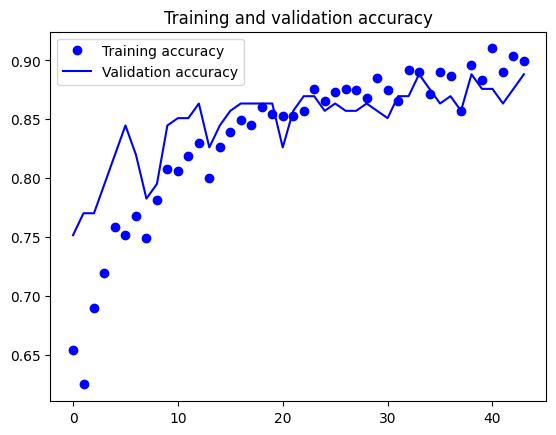

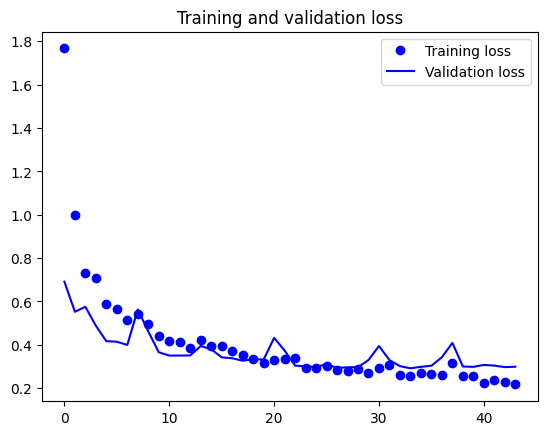

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

7/7 [==============================] - 10s 1s/step
The first 5 predictions: ['fire_images', 'fire_images', 'fire_images', 'fire_images', 'fire_images']
